# Jupyter notebook that generates Figures 2, 3, 4(a,c), 5(b) from the paper

## Part 1: collect all the data

In [1]:
import pickle
import pandas as pd
from pathlib import Path
import numpy as np
import copy
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

from tqdm import tqdm
tqdm.pandas()

sys.path.append('../code')
from utils import compute_additional_fields

In [2]:
def aggregate_pickles(all_pickles_paths, dataset_name):
    all_res = []
    
    for fname in all_pickles_paths:
        try:
            res = pickle.load(open(fname,'rb'))
        except (AttributeError, EOFError, TypeError) as e:
            print(e)
            print(fname)
            continue
        res.update(vars(res['args']))
        all_res.append(res)

    df_all = pd.DataFrame(all_res, columns=all_res[0].keys())
    df_all = compute_additional_fields(df_all, dataset_name=dataset_name)
    df_all.drop(columns=['qkern_matrix_train', 'qkern_matrix_test'], inplace=True)
    return df_all

In [3]:
dfs = {}

folders = [
    ("../data/results/IQP", "fashion-mnist"),
    ("../data/results/IQP_kmnist", "kmnist"),
    ("../data/results/IQP_plasticc/", "plasticc"),
    ("../data/results/control_evo_time", "fashion-mnist"),
    ("../data/results/control_evo_time_kmnist/", "kmnist"),
    ("../data/results/control_evo_time_plasticc/", "plasticc"),
]

for folder, dataset_name in folders:
    label = Path(folder).stem
    if "IQP" in folder:
        prefix = "IQP"
    else:
        prefix = "dim"
    all_pickles_paths = list(Path(folder).glob(f"{prefix}*.p"))
    npickles = len(all_pickles_paths)
    # check if the data in the pickles has been aggregated before
    # if not, compute an aggregated pickle with all the extra pickles
    must_reaggregate = True
    path_aggregated = Path(folder, "aggregated.p")
    if path_aggregated.exists():
        aggregated_df = pickle.load(open(path_aggregated, "rb"))
        if len(aggregated_df) == npickles:
            must_reaggregate = False
            print(f"For {folder}, using aggregated pickle from {path_aggregated}")
            dfs[label] = copy.deepcopy(aggregated_df)
    if must_reaggregate:
        aggregated_df = aggregate_pickles(all_pickles_paths, dataset_name)
        dfs[label] = copy.deepcopy(aggregated_df)
        print(f"For {folder}, saving aggregated pickle in {path_aggregated}")
        pickle.dump(aggregated_df, open(path_aggregated, "wb"))
    dfs[label] = dfs[label][dfs[label]['dataset_dim'] <= 22] 
    if "IQP" in folder:
        dfs[label]['Number of qubits'] = dfs[label]['dataset_dim']
    else:
        dfs[label]['Number of qubits'] = dfs[label]['dataset_dim'] + 1

100%|██████████| 373/373 [10:42<00:00,  1.72s/it]  


For ../data/results/IQP, saving aggregated pickle in ../data/results/IQP/aggregated.p


100%|██████████| 133/133 [02:28<00:00,  1.11s/it]


For ../data/results/IQP_kmnist, saving aggregated pickle in ../data/results/IQP_kmnist/aggregated.p


100%|██████████| 140/140 [03:50<00:00,  1.65s/it]


For ../data/results/IQP_plasticc/, saving aggregated pickle in ../data/results/IQP_plasticc/aggregated.p


100%|██████████| 735/735 [09:53<00:00,  1.24it/s]


For ../data/results/control_evo_time, saving aggregated pickle in ../data/results/control_evo_time/aggregated.p


100%|██████████| 729/729 [09:15<00:00,  1.31it/s]


For ../data/results/control_evo_time_kmnist/, saving aggregated pickle in ../data/results/control_evo_time_kmnist/aggregated.p


100%|██████████| 725/725 [14:06<00:00,  1.17s/it]


For ../data/results/control_evo_time_plasticc/, saving aggregated pickle in ../data/results/control_evo_time_plasticc/aggregated.p


# Main results plot for the manuscript

In [4]:
label2dataset = {Path(x).stem : y for x,y in folders}
label2dataset['IQP'] = 'fmnist'
label2dataset['control_evo_time'] = 'fmnist'

pretty_print_dict = {
    'test_score' : 'Prediction accuracy',
    'train_score' : 'Train accuracy',
    'evo_time' : 'Scaling factor',
    'scaling_factor' : 'Scaling factor',
}

palette = sns.color_palette("viridis",23)
legend_elements = []

def plot_one_score(df, ax, metric_to_plot, x_axis_metric, legend=False):
    """
    Plot one
    """
    dims=list(sorted(set(df['Number of qubits'])))

    for idx2, dim in enumerate(dims):
        to_plot = df[
            (df['Number of qubits'] == dim)
        ]
        x = sorted(set(to_plot[x_axis_metric]))
        x = [ii for ii in x if ii <= 1]
        y = [to_plot[
            to_plot[x_axis_metric] == evo_time
        ][metric_to_plot].mean() for evo_time in x]
        lp = ax.plot(
            x,y,
            label=dim, 
            color=palette[dim-3]
        )
        if legend:
            if (x_axis_metric == 'evo_time' and dim == 23) or (x_axis_metric == 'scaling_factor'):
                legend_elements.append(lp[0])
    ax.set_xscale("log")    
    ax.set_xlabel(pretty_print_dict[x_axis_metric])
    # Shrink current axis's height by 20% on the top
    box = ax.get_position()
    ax.set_position([box.x0, box.y0,
                     box.width, box.height * 0.7])
    

def plot_scores_IQP(dfs, metric_to_plot):
    """
    Plot test score for IQP
    """
    labels = ['IQP', 'IQP_kmnist', 'IQP_plasticc']
    # \textwidth is 6.92654 in
    f, ax = plt.subplots(1, len(labels), figsize=(1.5*6.92654, 2*6.92654/4), sharey=True)
    plt.subplots_adjust(wspace=0.01)
    
    for idx, label in enumerate(labels):
        is_leftmost = idx==0
        is_rightmost = idx==len(labels)-1
        plot_one_score(dfs[label], ax[idx], metric_to_plot, 'scaling_factor', legend = idx==1)
        ax[idx].set_title(r"\texttt{"+label2dataset[label]+r"}")
        if is_leftmost:
            ax[idx].set_ylabel(pretty_print_dict[metric_to_plot])
            ax[idx].set_yticks([0.5, 0.6, 0.7, 0.8, 0.9])
        else:
            ax[idx].yaxis.set_ticks_position('none')
            
    for one_ax in ax:
        lp_r = one_ax.hlines(y=0.5, xmin=one_ax.get_xlim()[0], xmax=one_ax.get_xlim()[1], 
                 color='k', linestyle='dashed', label='Random guess')
            
    ax[1].legend(
        handles=legend_elements[1:]+[legend_elements[0], lp_r],
        title='Number of qubits',
        loc='upper center', 
        bbox_to_anchor=(0.5, 1.55), 
        ncol=11, 
        labelspacing=0.1,
        columnspacing=1,
    )

            
def plot_scores_HamEvo(dfs, metric_to_plot, n_trotter):
    """
    Plot test score for HamEvo
    """
    labels = ['control_evo_time', 'control_evo_time_kmnist', 'control_evo_time_plasticc']
    # \textwidth is 6.92654 in
    f, ax = plt.subplots(1, len(labels), figsize=(1.5*6.92654, 2*6.92654/4), sharey=True)
    plt.subplots_adjust(wspace=0.01)
    
    for idx, label in enumerate(labels):
        is_leftmost = idx==0
        is_rightmost = idx==len(labels)-1
        df_to_plot = dfs[label]
        plot_one_score(df_to_plot[df_to_plot['n_trotter'] == n_trotter], ax[idx], metric_to_plot, 'evo_time', legend= idx==1)
        ax[idx].set_title(r"\texttt{"+label2dataset[label]+r"}")
        if is_leftmost:
            ax[idx].set_ylabel(pretty_print_dict[metric_to_plot])
            ax[idx].set_yticks([0.5, 0.6, 0.7, 0.8, 0.9])
        else:
            ax[idx].yaxis.set_ticks_position('none')
            
    for one_ax in ax:
        lp_r = one_ax.hlines(y=0.5, xmin=one_ax.get_xlim()[0], xmax=one_ax.get_xlim()[1], 
                 color='k', linestyle='dashed', label='Random guess')




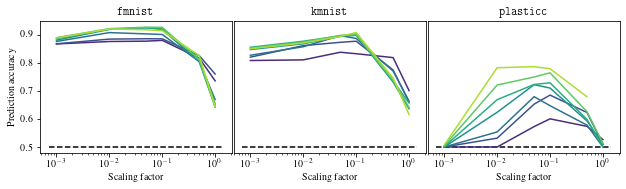

In [5]:
plot_scores_HamEvo(dfs, 'test_score', 40)
plt.savefig('HamEvo_test_accuracy.pdf')

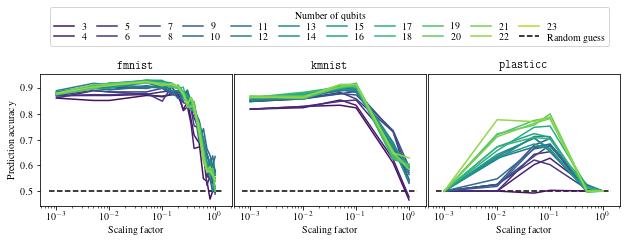

In [6]:
plot_scores_IQP(dfs, 'test_score')
plt.savefig('IQP_test_accuracy.pdf')

# Plots with additional values of Trotter steps for the appendix

In [8]:
label2dataset = {Path(x).stem : y for x,y in folders}
label2dataset['IQP'] = 'fmnist'
label2dataset['control_evo_time'] = 'fmnist'

pretty_print_dict = {
    'test_score' : 'Prediction accuracy',
    'train_score' : 'Train accuracy',
    'evo_time' : 'Scaling factor',
    'scaling_factor' : 'Scaling factor',
}

palette = sns.color_palette("viridis",23)
legend_elements = []

def plot_one_score(df, ax, metric_to_plot, x_axis_metric, legend=False):
    """
    Plot one
    """
    dims=list(sorted(set(df['Number of qubits'])))

    for idx2, dim in enumerate(dims):
        to_plot = df[
            (df['Number of qubits'] == dim)
        ]
        x = sorted(set(to_plot[x_axis_metric]))
        x = [ii for ii in x if ii <= 1]
        y = [to_plot[
            to_plot[x_axis_metric] == evo_time
        ][metric_to_plot].mean() for evo_time in x]
        lp = ax.plot(
            x,y,
            label=dim, 
            color=palette[dim-3]
        )
        if legend:
            legend_elements.append(lp[0])
    ax.set_xscale("log")    
    ax.set_xlabel(pretty_print_dict[x_axis_metric])
    # Shrink current axis's height by 20% on the top
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.7])
    
            
def plot_scores_HamEvo(dfs, metric_to_plot, n_trotter, plot_legend=False):
    """
    Plot test score for HamEvo
    """
    labels = ['control_evo_time', 'control_evo_time_kmnist', 'control_evo_time_plasticc']
    # \textwidth is 6.92654 in
    f, ax = plt.subplots(1, len(labels), figsize=(1.5*6.92654, 2*6.92654/4), sharey=True)
    plt.subplots_adjust(wspace=0.01)
    
    for idx, label in enumerate(labels):
        is_leftmost = idx==0
        is_rightmost = idx==len(labels)-1
        df_to_plot = dfs[label]
        plot_one_score(df_to_plot[df_to_plot['n_trotter'] == n_trotter], ax[idx], metric_to_plot, 'evo_time', legend= ((idx==1) and plot_legend))
        ax[idx].set_title(r"\texttt{"+label2dataset[label]+r"}")
        if is_leftmost:
            ax[idx].set_ylabel(pretty_print_dict[metric_to_plot])
            ax[idx].set_yticks([0.5, 0.6, 0.7, 0.8, 0.9])
        else:
            ax[idx].yaxis.set_ticks_position('none')
    
    f.suptitle(r'$T='+str(n_trotter)+r'$', y=0.05)
            
    for one_ax in ax:
        lp_r = one_ax.hlines(y=0.5, xmin=one_ax.get_xlim()[0], xmax=one_ax.get_xlim()[1], 
                 color='k', linestyle='dashed', label='Random guess')
    legend_elements.append(lp_r)
    
    if plot_legend:
        ax[1].legend(
            handles=legend_elements,
            title='Number of qubits',
            loc='upper center', 
            bbox_to_anchor=(0.5, 1.45), 
            ncol=11, 
            labelspacing=0.1,
            columnspacing=1,
        )



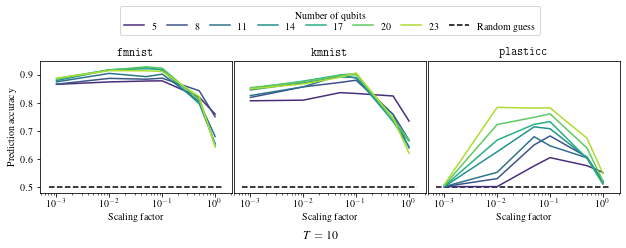

In [9]:
plot_scores_HamEvo(dfs, 'test_score', 10, plot_legend=True)
plt.savefig('HamEvo_test_accuracy_ntrotter_10.pdf')

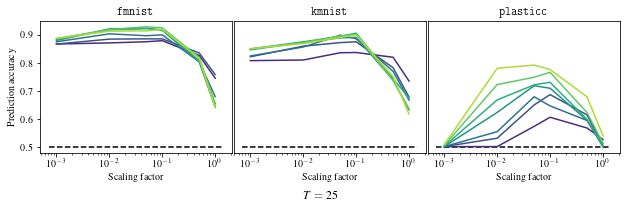

In [10]:
plot_scores_HamEvo(dfs, 'test_score', 25, plot_legend=False)
plt.savefig('HamEvo_test_accuracy_ntrotter_25.pdf')

# Scaling factor and the exponential scaling of the kernel value

In [11]:
from utils import get_dataset, get_quantum_kernel, IQPStyleFeatureMap

n = 20

X_train, X_test, y_train, y_test = get_dataset(
    'fashion-mnist', n, 3, 3)

FeatureMap = IQPStyleFeatureMap(n)
qkern = get_quantum_kernel(FeatureMap)

idx1, idx2 = (0,0)
equal = y_test[idx1] == y_train[idx2]

factors = np.hstack([np.logspace(-3, 1, 100)[:75], 1.0, np.logspace(-3, 1, 100)[75:]])
k_vals = []

for scaling_factor in tqdm(factors):
    x_train = np.atleast_2d(X_train[idx2] * scaling_factor)
    x_test = np.atleast_2d(X_test[idx1] * scaling_factor)

    qkern_matrix_test = qkern.evaluate(x_vec=x_test, y_vec=x_train)
    assert(qkern_matrix_test.shape == (1,1))
    k_vals.append(qkern_matrix_test[0][0])

100%|██████████| 101/101 [04:04<00:00,  2.42s/it]


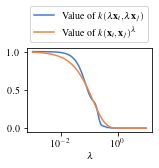

In [12]:
import matplotlib.pyplot as plt

f, ax=plt.subplots(figsize=(2*6.92654/6, 2*6.92654/4.5))

assert np.isclose(factors[75], 1.0)

ax.set_xscale('log')
ax.plot(factors, k_vals, label=r'Value of $k(\lambda \mathbf{x}_i,\lambda \mathbf{x}_j)$', c=sns.color_palette("muted")[0])
ax.plot(factors, [k_vals[75]**x for x in factors], label=r'Value of $k(\mathbf{x}_i, \mathbf{x}_j)^\lambda$', c=sns.color_palette("muted")[1])
plt.legend(loc='upper center', 
        bbox_to_anchor=(0.5, 1.55))
plt.xlabel(r'$\lambda$')
plt.tight_layout()
plt.savefig(f'IQP_kern_value_vary_lambda.pdf')

# Scaling of kernel values

In [13]:
from utils import get_dataset, get_quantum_kernel, IQPStyleFeatureMap

nqubits = []
k_vals = []

for n in tqdm(range(3,25)):
    X_train, X_test, y_train, y_test = get_dataset(
        'fashion-mnist', n, 3, 3)
    
    x_train = np.atleast_2d(X_train[1])
    x_test = np.atleast_2d(X_test[1])
    
    x_train /= np.std(x_train)
    x_test /= np.std(x_test)


    FeatureMap = IQPStyleFeatureMap(n)
    qkern = get_quantum_kernel(FeatureMap)
    
    qkern_matrix_test = qkern.evaluate(x_vec=x_test, y_vec=x_train)
    assert(qkern_matrix_test.shape == (1,1))
    nqubits.append(n)
    k_vals.append(qkern_matrix_test[0][0])

100%|██████████| 22/22 [03:29<00:00,  9.52s/it]


In [14]:
from utils import get_quantum_kernel, IQPStyleFeatureMap

nqubits_uniform = []
k_vals_uniform = []

np.random.seed(1)

for n in tqdm(range(3,25)):
    x_train = np.atleast_2d(np.random.normal(loc=0.0, scale=1, size=n))
    x_test = np.atleast_2d(np.random.normal(loc=0.0, scale=1, size=n))

    FeatureMap = IQPStyleFeatureMap(n)
    qkern = get_quantum_kernel(FeatureMap)
    
    qkern_matrix_test = qkern.evaluate(x_vec=x_test, y_vec=x_train)
    assert(qkern_matrix_test.shape == (1,1))
    nqubits_uniform.append(n)
    k_vals_uniform.append(qkern_matrix_test[0][0])
    

100%|██████████| 22/22 [00:43<00:00,  2.00s/it]


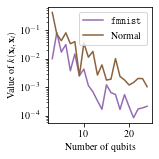

In [15]:
import matplotlib.pyplot as plt

f, ax=plt.subplots(figsize=(2*6.92654/6, 2*6.92654/6))

ax.plot(nqubits, k_vals, label=r'\texttt{fmnist}', c=sns.color_palette("muted")[4])
ax.plot(nqubits_uniform, k_vals_uniform, label=r'Normal', c=sns.color_palette("muted")[5])
ax.legend()
ax.set_yscale('log')
ax.set_ylabel(r'Value of $k(\mathbf{x}_i, \mathbf{x}_i)$')
ax.set_xlabel("Number of qubits")
plt.tight_layout()
plt.savefig('IQP_kern_value_vary_nqubits.pdf')

# 2d plots of kernel matrix vs identity and test score

In [16]:
print(dfs.keys())
df_to_plot = dfs['IQP']
# df_to_plot = df_to_plot[df_to_plot['n_trotter'] == 40]
# xaxis_name = 'evo_time'
xaxis_name = 'scaling_factor'

dict_keys(['IQP', 'IQP_kmnist', 'IQP_plasticc', 'control_evo_time', 'control_evo_time_kmnist', 'control_evo_time_plasticc'])


In [17]:
df_to_plot.describe()

,score,K_train_time,K_test_time,dataset_dim,scaling_factor,test_score,train_score,n_support_ave,C,norm(qkern_matrix_train - identity),Number of qubits
count,340.000000,340.000000,340.000000,340.00000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.00000
mean,0.715294,621.411485,539.235544,12.50000,0.371529,0.783217,0.947219,269.305882,130.317385,271.905071,12.50000
std,0.165783,971.809982,771.517216,5.77478,0.317953,0.137857,0.091716,122.941309,301.006623,307.860224,5.77478
min,0.445000,31.138040,12.103693,3.00000,0.001000,0.468596,0.500000,77.500000,0.006000,0.972599,3.00000
25%,0.545000,100.555986,56.553173,7.75000,0.100000,0.652673,0.926081,142.250000,2.000000,14.664606,7.75000
50%,0.800000,152.690278,153.902140,12.50000,0.300000,0.851723,0.986028,294.250000,3.000000,109.984050,12.50000
75%,0.870000,714.529047,695.835070,17.25000,0.600000,0.891569,1.000000,399.500000,32.000000,522.669431,17.25000
max,0.915000,5130.855109,3994.958002,22.00000,1.000000,0.931766,1.000000,400.000000,1024.000000,799.463944,22.00000


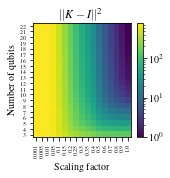

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

plt.figure(figsize=(2*6.92654/5.5, 2*6.92654/5.5))

metric_to_plot = 'norm(qkern_matrix_train - identity)'

factors=list(sorted(set(df_to_plot[xaxis_name])))

dims=list(sorted(set(df_to_plot['Number of qubits'])))

to_plot = np.zeros((len(dims), len(factors)))

for idx1, dim in enumerate(dims):
    for idx2, factor in enumerate(factors):
        val = df_to_plot[
            (df_to_plot[xaxis_name] == factor) & (df_to_plot['Number of qubits'] == dim)
        ][metric_to_plot].squeeze()
        if isinstance(val, float):
            to_plot[idx1][idx2] = val
        else:
            to_plot[idx1][idx2] = val.mean()
plt.imshow(
    to_plot, 
    origin="lower", 
    norm=LogNorm()
)
plt.xticks(range(len(factors)),factors, rotation=90, fontsize=6)
plt.xlabel('Scaling factor')
plt.yticks(range(len(dims)),dims, fontsize=6)
plt.ylabel('Number of qubits')
plt.title(r"$||K-I||^2$")
plt.colorbar()
plt.tight_layout()
plt.savefig('IQP_norm_K-identity_2d.pdf')
plt.show()

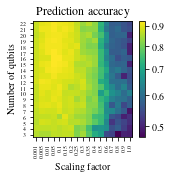

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

plt.figure(figsize=(2*6.92654/5.5, 2*6.92654/5.5))

metric_to_plot = 'test_score'

factors=list(sorted(set(df_to_plot[xaxis_name])))

dims=list(sorted(set(df_to_plot['dataset_dim'])))

to_plot = np.zeros((len(dims), len(factors)))

for idx1, dim in enumerate(dims):
    for idx2, factor in enumerate(factors):
        val = df_to_plot[
            (df_to_plot[xaxis_name] == factor) & (df_to_plot['dataset_dim'] == dim)
        ][metric_to_plot].squeeze().mean()
        if isinstance(val, float):
            to_plot[idx1][idx2] = val
plt.imshow(
    to_plot, 
    origin="lower", 
    norm=LogNorm()
)
plt.xticks(range(len(factors)),factors, rotation=90, fontsize=6)
plt.xlabel('Scaling factor')
plt.yticks(range(len(dims)),dims, fontsize=6)
plt.ylabel('Number of qubits')
plt.title(r"Prediction accuracy")
plt.colorbar(ticks=[0.5, 0.6, 0.7, 0.8, 0.9], format='%.1f')
plt.tight_layout()
plt.savefig('IQP_test_score_2d.pdf')
plt.show()

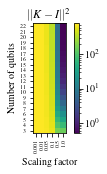

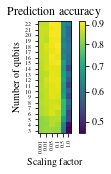

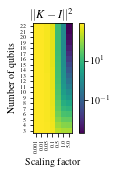

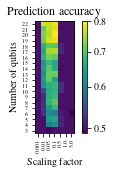

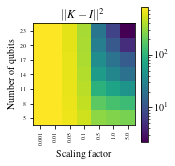

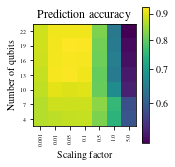

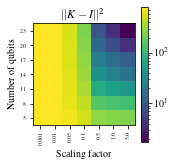

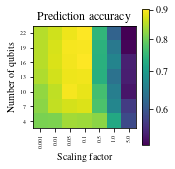

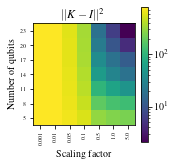

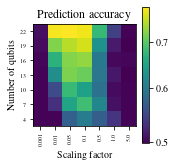

In [20]:
for label in ['IQP_kmnist', 'IQP_plasticc', 'control_evo_time', 'control_evo_time_kmnist', 'control_evo_time_plasticc']:
    df_to_plot = dfs[label]
    # df_to_plot = df_to_plot[df_to_plot['n_trotter'] == 40]
    if 'IQP' in label:
        xaxis_name = 'scaling_factor'
    else:
        xaxis_name = 'evo_time'

    import seaborn as sns
    import matplotlib.pyplot as plt
    from matplotlib.colors import LogNorm

    plt.figure(figsize=(2*6.92654/5.5, 2*6.92654/5.5))

    metric_to_plot = 'norm(qkern_matrix_train - identity)'

    factors=list(sorted(set(df_to_plot[xaxis_name])))

    dims=list(sorted(set(df_to_plot['Number of qubits'])))

    to_plot = np.zeros((len(dims), len(factors)))

    for idx1, dim in enumerate(dims):
        for idx2, factor in enumerate(factors):
            val = df_to_plot[
                (df_to_plot[xaxis_name] == factor) & (df_to_plot['Number of qubits'] == dim)
            ][metric_to_plot].squeeze()
            if isinstance(val, float):
                to_plot[idx1][idx2] = val
            else:
                to_plot[idx1][idx2] = val.mean()
    plt.imshow(
        to_plot, 
        origin="lower", 
        norm=LogNorm()
    )
    plt.xticks(range(len(factors)),factors, rotation=90, fontsize=6)
    plt.xlabel('Scaling factor')
    plt.yticks(range(len(dims)),dims, fontsize=6)
    plt.ylabel('Number of qubits')
    plt.title(r"$||K-I||^2$")
    plt.colorbar()
    plt.tight_layout()
    plt.savefig(f'{label}_norm_K-identity_2d.pdf')
    plt.show()

    import seaborn as sns
    import matplotlib.pyplot as plt
    from matplotlib.colors import LogNorm

    plt.figure(figsize=(2*6.92654/5.5, 2*6.92654/5.5))

    metric_to_plot = 'test_score'

    factors=list(sorted(set(df_to_plot[xaxis_name])))

    dims=list(sorted(set(df_to_plot['dataset_dim'])))

    to_plot = np.zeros((len(dims), len(factors)))

    for idx1, dim in enumerate(dims):
        for idx2, factor in enumerate(factors):
            val = df_to_plot[
                (df_to_plot[xaxis_name] == factor) & (df_to_plot['dataset_dim'] == dim)
            ][metric_to_plot].squeeze().mean()
            if isinstance(val, float):
                to_plot[idx1][idx2] = val
    plt.imshow(
        to_plot, 
        origin="lower", 
        norm=LogNorm()
    )
    plt.xticks(range(len(factors)),factors, rotation=90, fontsize=6)
    plt.xlabel('Scaling factor')
    plt.yticks(range(len(dims)),dims, fontsize=6)
    plt.ylabel('Number of qubits')
    plt.title(r"Prediction accuracy")
    plt.colorbar(ticks=[0.5, 0.6, 0.7, 0.8, 0.9], format='%.1f')
    plt.tight_layout()
    plt.savefig(f'{label}_test_score_2d.pdf')
    plt.show()

# Performance with best parameters 

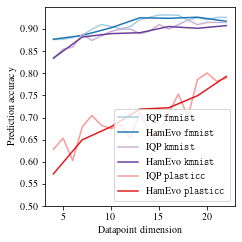

In [23]:
def get_best_params_for_label(label):
    if label == 'IQP':
        return {'scaling_factor' : 0.05}
    elif label == 'IQP_kmnist':
        return {'scaling_factor' : 0.10}
    elif label == 'IQP_plasticc':
        return {'scaling_factor' : 0.10}
    elif label == 'control_evo_time':
        return {'evo_time' : 0.05, 'n_trotter': 40}
    elif label == 'control_evo_time_kmnist':
        return {'evo_time' : 0.10, 'n_trotter': 10}
    elif label == 'control_evo_time_plasticc':
        return {'evo_time' : 0.05, 'n_trotter': 25}
    else:
        raise ValueError(f'Unknown label: {label}')

def avoid_green(i):
    if i in [2,3]:
        return i+6
    else:
        return i

metric_to_plot = 'test_score'

f, ax=plt.subplots(figsize=(2*6.92654/4, 2*6.92654/4))

for idx, label in enumerate(['IQP', 'control_evo_time', 'IQP_kmnist', 'control_evo_time_kmnist', 'IQP_plasticc', 'control_evo_time_plasticc']):
    df_to_plot = dfs[label]
    
    params = get_best_params_for_label(label)
    
    if 'IQP' in label:
        feature_map_name = 'IQP'
        to_plot = df_to_plot[
            (df_to_plot['scaling_factor'] == params['scaling_factor'])
        ]
    else:
        feature_map_name = 'HamEvo'
        to_plot = df_to_plot[
            (df_to_plot['evo_time'] == params['evo_time']) & (df_to_plot['n_trotter'] == params['n_trotter'])
        ]
        
    x = sorted(set(to_plot['dataset_dim']))
    x = [tmp for tmp in x if tmp >= 4]
    y = [to_plot[
        to_plot['dataset_dim'] == dim
    ][metric_to_plot].mean() for dim in x]
    ax.plot(
        x,y,
        label=feature_map_name + r" \texttt{" + label2dataset[label] + r"}", 
        color=sns.color_palette("Paired")[avoid_green(idx)]
    )
ax.set_ylim(bottom=0.5)
ax.set_ylabel(r"Prediction accuracy")
ax.set_xlabel(r"Datapoint dimension")
ax.legend()
plt.tight_layout()
plt.savefig('performance_vs_nqubits_all.pdf')

# Under and over fitting

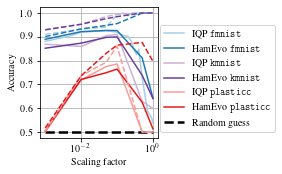

In [24]:
def avoid_green(i):
    if i in [2,3]:
        return i+6
    else:
        return i

metric_to_plot = 'test_score'

f, ax=plt.subplots(figsize=(2*6.92654/2.65, 2*6.92654/5.5))

for idx, label in enumerate(['IQP', 'control_evo_time', 'IQP_kmnist', 'control_evo_time_kmnist', 'IQP_plasticc', 'control_evo_time_plasticc']):
    df_to_plot = dfs[label]
    
    if 'IQP' in label:
        feature_map_name = 'IQP'
        xaxis_name = 'scaling_factor'
        to_plot = df_to_plot[
            (df_to_plot['dataset_dim'] == 19)
        ]
    else:
        feature_map_name = 'HamEvo'
        xaxis_name = 'evo_time'
        to_plot = df_to_plot[
            (df_to_plot['dataset_dim'] == 19) & (df_to_plot['n_trotter'] == 40)
        ]
        
    x = sorted(set(to_plot[xaxis_name]))
    x = [tmp for tmp in x if tmp <= 1]
    y = [to_plot[
        to_plot[xaxis_name] == dim
    ][metric_to_plot].mean() for dim in x]
    ax.plot(
        x,y,
        label=feature_map_name + r" \texttt{" + label2dataset[label] + r"}", 
        color=sns.color_palette("Paired")[avoid_green(idx)]
    )
    

ax.hlines(y=0.5, xmin=0.001, xmax=1, 
                 color='k', linestyle='dashed', label='Random guess', linewidths=2.5)

ax.legend(loc='upper center', 
        bbox_to_anchor=(1.5, 0.9))

metric_to_plot = 'train_score'

for idx, label in enumerate(['IQP', 'control_evo_time', 'IQP_kmnist', 'control_evo_time_kmnist', 'IQP_plasticc', 'control_evo_time_plasticc']):
    df_to_plot = dfs[label]
    
    if 'IQP' in label:
        feature_map_name = 'IQP'
        xaxis_name = 'scaling_factor'
        to_plot = df_to_plot[
            (df_to_plot['dataset_dim'] == 19)
        ]
    else:
        feature_map_name = 'HamEvo'
        xaxis_name = 'evo_time'
        to_plot = df_to_plot[
            (df_to_plot['dataset_dim'] == 19) & (df_to_plot['n_trotter'] == 40)
        ]
        
    x = sorted(set(to_plot[xaxis_name]))
    x = [tmp for tmp in x if tmp <= 1]
    y = [to_plot[
        to_plot[xaxis_name] == dim
    ][metric_to_plot].mean() for dim in x]
    ax.plot(
        x,y,
        label=feature_map_name + r" \texttt{" + label2dataset[label] + r"}", 
        color=sns.color_palette("Paired")[avoid_green(idx)],
        linestyle='dashed'
    )
    
# ax.set_ylim(bottom=0.57)
ax.set_ylabel(r"Accuracy")
ax.set_xlabel(r"Scaling factor")
ax.set_xscale('log')
plt.grid()
plt.tight_layout()
plt.savefig('under_over_fitting_all.pdf')

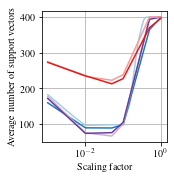

In [25]:
def avoid_green(i):
    if i in [2,3]:
        return i+6
    else:
        return i

metric_to_plot = 'n_support_ave'

f, ax=plt.subplots(figsize=(2*6.92654/5.5, 2*6.92654/5.5))

for idx, label in enumerate(['IQP', 'control_evo_time', 'IQP_kmnist', 'control_evo_time_kmnist', 'IQP_plasticc', 'control_evo_time_plasticc']):
    df_to_plot = dfs[label]
    
    if 'IQP' in label:
        feature_map_name = 'IQP'
        xaxis_name = 'scaling_factor'
        to_plot = df_to_plot[
            (df_to_plot['dataset_dim'] == 19)
        ]
    else:
        feature_map_name = 'HamEvo'
        xaxis_name = 'evo_time'
        to_plot = df_to_plot[
            (df_to_plot['dataset_dim'] == 19) & (df_to_plot['n_trotter'] == 40)
        ]
        
    x = sorted(set(to_plot[xaxis_name]))
    x = [tmp for tmp in x if tmp <= 1]
    y = [to_plot[
        to_plot[xaxis_name] == dim
    ][metric_to_plot].mean() for dim in x]
    ax.plot(
        x,y,
        label=feature_map_name + r" \texttt{" + label2dataset[label] + r"}", 
        color=sns.color_palette("Paired")[avoid_green(idx)]
    )
    
    
# ax.set_ylim(bottom=0.57)
ax.set_ylabel(r"Average number of support vectors")
ax.set_xlabel(r"Scaling factor")
ax.set_xscale('log')
# ax.legend()
plt.grid()
plt.tight_layout()
plt.savefig('nsupport_all.pdf')